# BDT - Background and Signal distribution

#### Using only the positive weights for the background and training/testing with all masses with their weight = 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import pandas as pd
import math

In [2]:
signal_all = pd.DataFrame()
signal_mass = [300, 420, 440, 460, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 2000]
for each in signal_mass:
    df_temp = pd.read_csv(str(each) + ".csv", index_col=0)
    df_temp["mass"] = each
    df_temp.drop(columns=["nTags", "MCChannelNumber", "mVHres"], inplace=True)
    signal_all = pd.concat([df_temp, signal_all], ignore_index=True)

background = pd.read_csv("background.csv", index_col=0)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

In [3]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2) #splitting bkg into train and test
train_signal, test_signal = train_test_split(signal_all, test_size=0.4, random_state=2) #splitting signal into train and test

train_y = len(train_bkg) * [0] + len(train_signal) * [1] #training set
test_y = len(test_bkg) * [0] + len(test_signal) * [1] #test set

train_x = pd.concat([train_bkg, train_signal], ignore_index=True) #training data
test_x = pd.concat([test_bkg, test_signal], ignore_index=True) #testing data

In [4]:
train_weight = train_x["weight"].to_numpy()
test_weight = test_x["weight"].to_numpy()
train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x_before = train_x.drop(columns=["mass"])
train_x = scaler.fit_transform(train_x.drop(columns=["mass"]))
test_x = scaler.transform(test_x.drop(columns=["mass"]))

In [6]:
test_signal_weight_org = test_signal["weight"].to_numpy()
test_signal_weight = []
for i in test_signal_weight_org: #Setting the weight of the test_signal to 1
    i = 1
    test_signal_weight.append(i)
    
train_signal_weight_org = train_signal["weight"].to_numpy()
train_signal_weight = []
for i in train_signal_weight_org: #Setting the weight of the train_signal to 1
    i = 1
    train_signal_weight.append(i)

In [7]:
test_bkg_weight = test_bkg["weight"].to_numpy()
positive_testbkg_weight = []
for i in test_bkg_weight:
    if i > 0:
        positive_testbkg_weight.append(i) #Only taking postive testing bkg weights
    else:
        i = 0
        positive_testbkg_weight.append(i) #Setting negative weight to 0
        
train_bkg_weight = train_bkg["weight"].to_numpy()
positive_trainbkg_weight = []
for i in train_bkg_weight:
    if i > 0:
        positive_trainbkg_weight.append(i) #Only taking postive training bkg weights
    else:
        i = 0
        positive_trainbkg_weight.append(i) #Setting negative weight to 0

In [8]:
def test_BDT(n, d, l):
    BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), algorithm="SAMME", 
                                 n_estimators=n, learning_rate=l).fit(train_x, train_y)
    
    bkg_train = BDT_clf.decision_function(train_bkg.drop(columns=["weight"]))
    signal_train = BDT_clf.decision_function(train_signal.drop(columns=["weight", "mass"]))
    bkg = BDT_clf.decision_function(test_bkg.drop(columns=["weight"]))
    signal = BDT_clf.decision_function(test_signal.drop(columns=["weight", "mass"]))
    
    c_max = 1
    c_min = -1
    
    plt.hist(bkg,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='dodgerblue',
             label="Testing Bkg")
    plt.hist(signal,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='orange',
             label="Testing Signal")
    plt.hist(bkg_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='limegreen', 
             label="Training Bkg")
    plt.hist(signal_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='m', 
             label="Training Signal")
    
    filename = "n={} d={} l={}".format(n,d,l)
    plt.xlabel('BDT output')
    plt.ylabel('Density')
    plt.legend(loc="upper right")
    plt.title(filename)
    plt.savefig("Figures/{}.png".format(filename), dpi=300)
    
    sighist, _ = np.histogram(signal, bins=bins, weights=test_signal_weight) #test signal weight
    bkghist, _ = np.histogram(bkg, bins=bins, weights=positive_testbkg_weight) #positive test bkg weight
    sighist_train, _ = np.histogram(signal_train, bins=bins, weights=train_signal_weight) #train signal weight
    bkghist_train, _ = np.histogram(bkg_train, bins=bins, weights=positive_trainbkg_weight) #positive train bkg weight
    
    portion = 0.4
    logsig = True
    
    backgrounds_content = np.array(bkghist)/portion
    signal_content = np.array(sighist)/portion
    backgrounds_content_train = np.array(bkghist_train)/portion
    signal_content_train = np.array(sighist_train)/portion
    
    total = 0
    
    if not logsig:
        testing_sig = sum(signal_content)/math.sqrt(sum(backgrounds_content))
        training_sig = sum(signal_content_train)/math.sqrt(sum(backgrounds_content_train))
        return testing_sig, training_sig

    for each_b, each_s in zip(backgrounds_content, signal_content):
        if each_b > 0 and each_s > 0:
            total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
    test_signif = "Testing significance for {} is:".format(filename), math.sqrt(total)

    for each_b, each_s in zip(backgrounds_content_train, signal_content_train):
        if each_b > 0 and each_s > 0:
            total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
    train_signif = "Training significance for {} is:".format(filename), math.sqrt(total)    

    return [test_signif, train_signif]

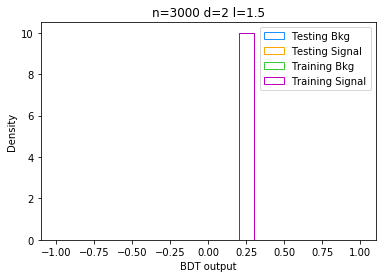

In [13]:
#l_testing = [0.1, 0.3, 0.5, 1.5] 

n_testing = 3000
d_testing = 2
l_testing = [1.5]
    
bins = np.linspace(-1,1,20)

for i in l_testing:
    plt.figure()
    signif = test_BDT(n_testing, d_testing, i) 
    
    test_sig_final = signif[0]
    train_sig_final = signif[1]
    
    with open("Sig.txt", "a") as output:
        output.write(str(test_sig_final) + '\n')
        output.write(str(train_sig_final) + '\n')